<a href="https://colab.research.google.com/github/CUOTR/Credit_Rating_Performance_Python_Project/blob/main/Credit_Rating_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PYTHON: CREDIT RATING PERFORMANCE**

# **Overview**

This project analyzes a  consumer loan dataset from KAGGLE  to evaluate the performance of the internal credit rating system (`sub_grade`).

The main objective is to assess whether the rating grades (from A1 to G5) effectively discriminate credit risk by examining actual

(`default rates`)(Charged Off loans) across different grades.

# I. EXTRACT, TRANSFORM, LOAD (ETL)


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/CREDIT_RATING.csv")

print(df.isnull().sum())
print(df.describe())
print(df.info())

id                        0
address_state             0
emp_length                0
emp_title              1087
home_ownership            0
loan_status               0
member_id                 0
purpose                   0
sub_grade                 0
term                      0
verification_status       0
annual_income             0
dti                       0
installment               0
int_rate                  0
loan_amount               0
total_acc                 0
total_payment             0
dtype: int64
                 id     member_id  annual_income           dti   installment  \
count  3.196300e+04  3.196300e+04   3.196300e+04  31963.000000  31963.000000   
mean   7.337336e+05  9.201666e+05   7.012571e+04      0.135312    329.247058   
std    1.858260e+05  2.211054e+05   6.488187e+04      0.066511    210.883700   
min    5.724500e+04  7.069900e+04   4.080000e+03      0.000000     16.250000   
25%    5.843730e+05  7.504905e+05   4.200000e+04      0.084400    169.780000   
50%

In [76]:
cols = ['annual_income', 'dti', 'loan_amount', 'installment']

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print(":", len(df))

df_clean = df.copy()
for col in cols:
    df_clean = remove_outliers(df_clean, col)

print("Số khoản vay sau khi loại outlier:", len(df_clean))
print("Đã loại bỏ:", len(df) - len(df_clean), "khoản vay nghi là outlier")

df = df_clean

: 31963
Số khoản vay sau khi loại outlier: 28817
Đã loại bỏ: 3146 khoản vay nghi là outlier


In [77]:
df.drop(columns=['emp_title'], inplace=True)

df['loan_term'] = df['term'].str.extract(r'(\d+)').astype(float).astype(int)

df['grade'] = df['sub_grade'].str[0]

df.drop(columns=['term'], inplace=True)
df.head(1)

,id,address_state,emp_length,home_ownership,loan_status,member_id,purpose,sub_grade,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment,loan_term,grade
0,1068350,IL,10+ years,MORTGAGE,Fully Paid,1302971,car,A1,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835,36,A


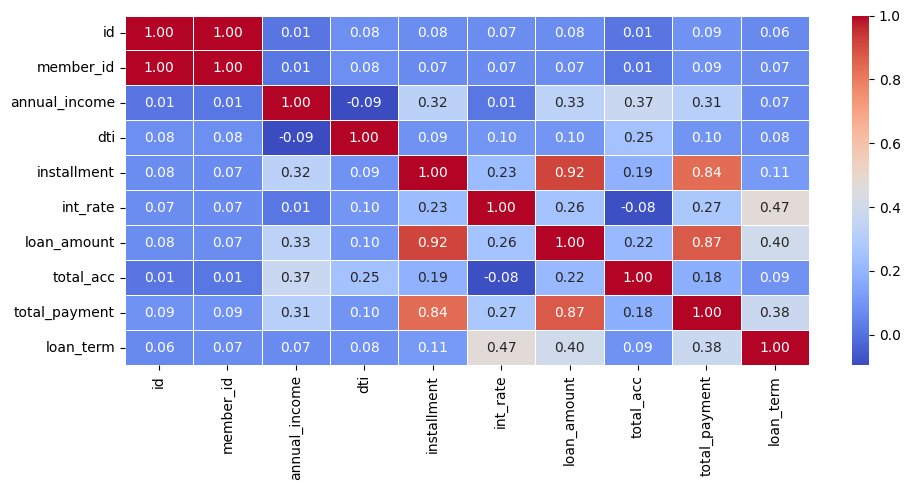

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.show()


# II. EXPLORATORY DATA ANALYSIS (EDA)

1. DEFAULT LOANS

In [79]:
df['is_default'] = df['loan_status'] == 'Charged Off'

total_loans = len(df)
default_loans = df['is_default'].sum()
default_rate = default_loans / total_loans * 100

print(f"TOTAL LOANS: {total_loans}")
print(f"DEFAULT LOANS: {default_loans}")
print(f"DEFAULT RATE: {default_rate:.2f}%")
print(df['loan_status'].value_counts())

TOTAL LOANS: 28817
DEFAULT LOANS: 4008
DEFAULT RATE: 13.91%
loan_status
Fully Paid     23899
Charged Off     4008
Current          910
Name: count, dtype: int64


In [80]:
df.groupby('loan_status')[['annual_income', 'dti', 'int_rate', 'loan_amount']].mean().round(4)

,annual_income,dti,int_rate,loan_amount
loan_status,,,,
Charged Off,55731.1096,0.1427,0.1376,10970.8957
Current,64082.0753,0.1514,0.1487,14737.2527
Fully Paid,61550.0140,0.1351,0.1143,9918.5960


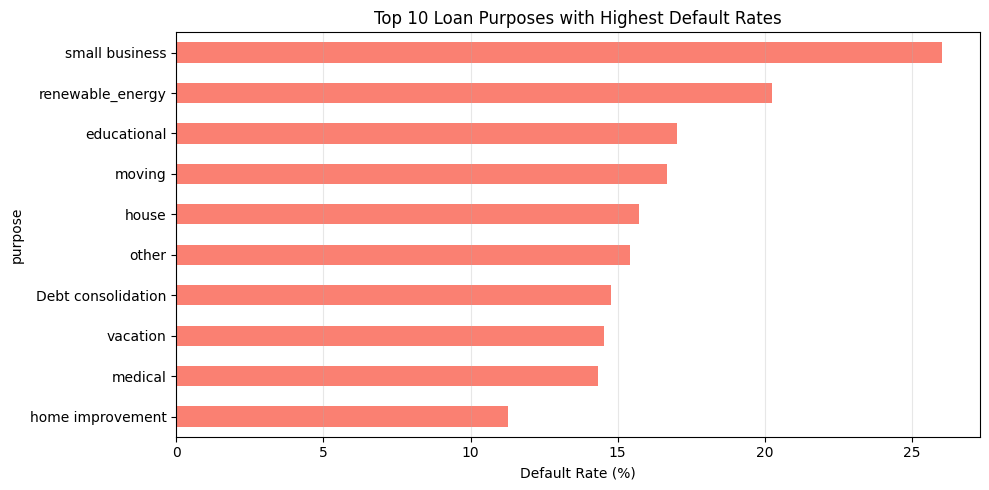

In [82]:
purpose_default_rates = df.groupby('purpose')['is_default'].mean() * 100

top10_default_rate = purpose_default_rates.sort_values(ascending=False).head(10)

top10_default_rate.plot.barh(color='salmon', figsize=(10, 5))

plt.title('Top 10 Loan Purposes with Highest Default Rates')
plt.xlabel('Default Rate (%)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

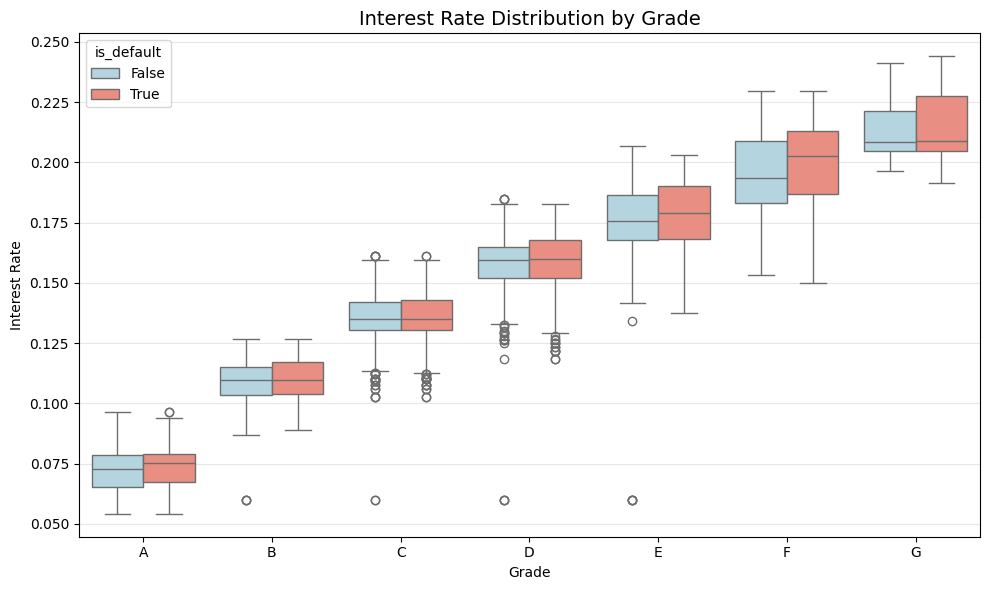

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.boxplot(x='grade', y='int_rate', data=df, hue='is_default', palette={0: 'lightblue', 1: 'salmon'})
plt.title('Interest Rate Distribution by Grade', fontsize=14)
plt.xlabel('Grade')
plt.ylabel('Interest Rate')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

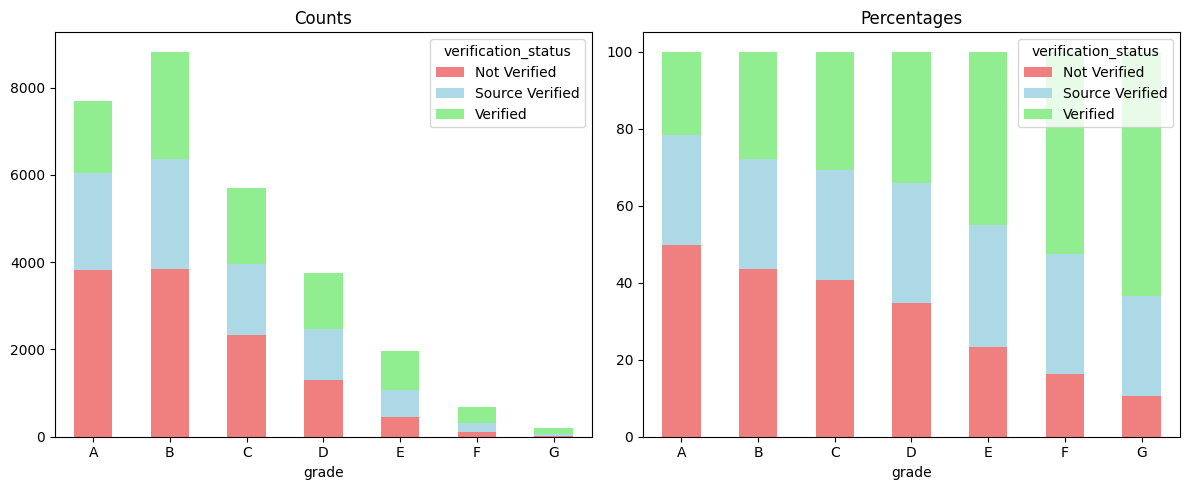

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

count = pd.crosstab(df['grade'], df['verification_status'])
percent = pd.crosstab(df['grade'], df['verification_status'], normalize='index') * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = ['lightcoral', 'lightblue', 'lightgreen']

count.plot.bar(stacked=True, color=colors, ax=ax1)
percent.plot.bar(stacked=True, color=colors, ax=ax2)

ax1.set_title('Counts')
ax2.set_title('Percentages')
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

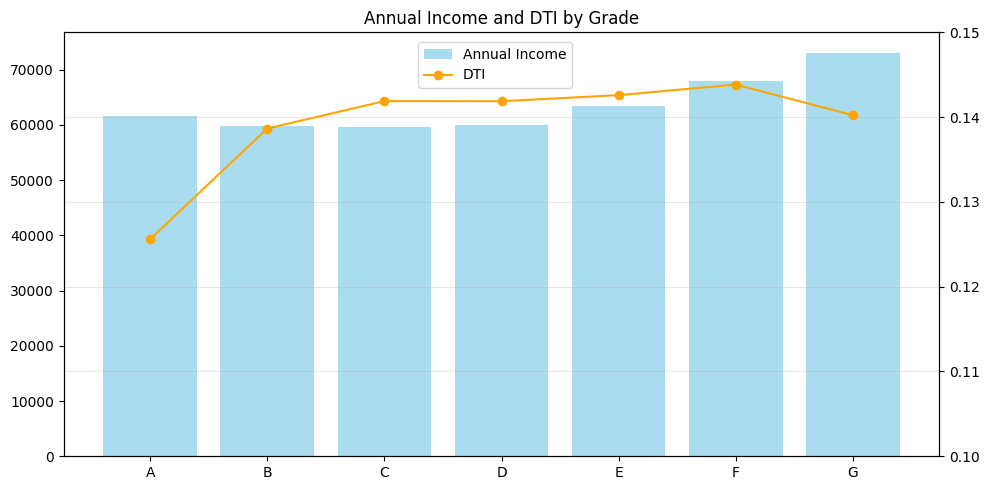

In [137]:
summary = df.groupby('grade')[['annual_income', 'dti']].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(summary.index, summary['annual_income'], color='skyblue', alpha=0.7, label='Annual Income')

ax2 = ax1.twinx()
ax2.plot(summary.index, summary['dti'], color='orange', marker='o', label='DTI')
ax2.set_ylim(0.1, 0.15)

plt.title('Annual Income and DTI by Grade')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

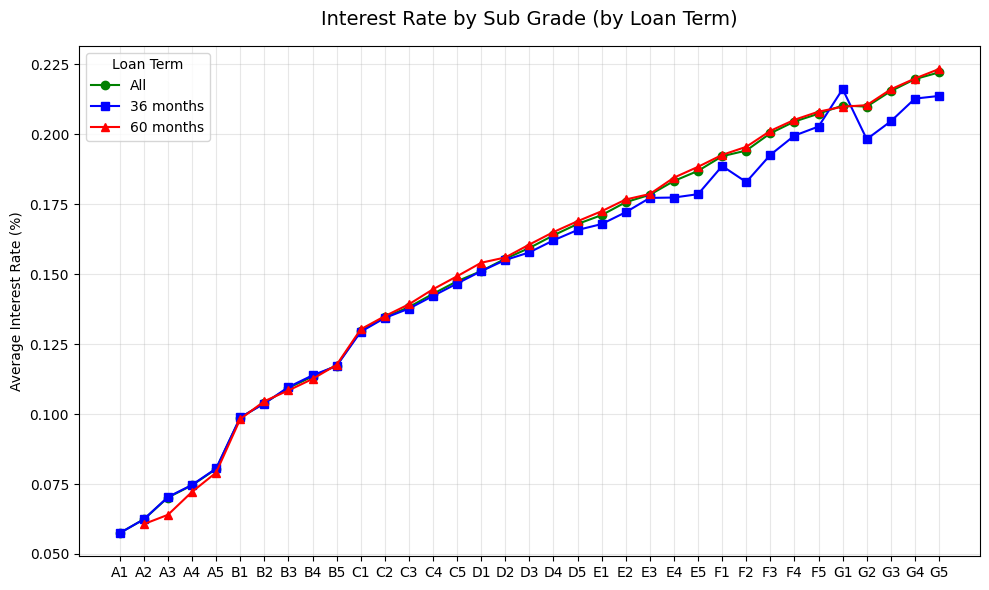

In [140]:
import matplotlib.pyplot as plt

int_sub = df.groupby('sub_grade')['int_rate'].mean()
int_36 = df[df['loan_term'] == 36].groupby('sub_grade')['int_rate'].mean()
int_60 = df[df['loan_term'] == 60].groupby('sub_grade')['int_rate'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(int_sub.index, int_sub.values, marker='o', label='All', color='green')
ax1.plot(int_36.index, int_36.values, marker='s', label='36 months', color='blue')
ax1.plot(int_60.index, int_60.values, marker='^', label='60 months', color='red')

ax1.set_title('Interest Rate by Sub Grade (by Loan Term)', fontsize=14, pad=15)
ax1.set_ylabel('Average Interest Rate (%)')
ax1.legend(title='Loan Term')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

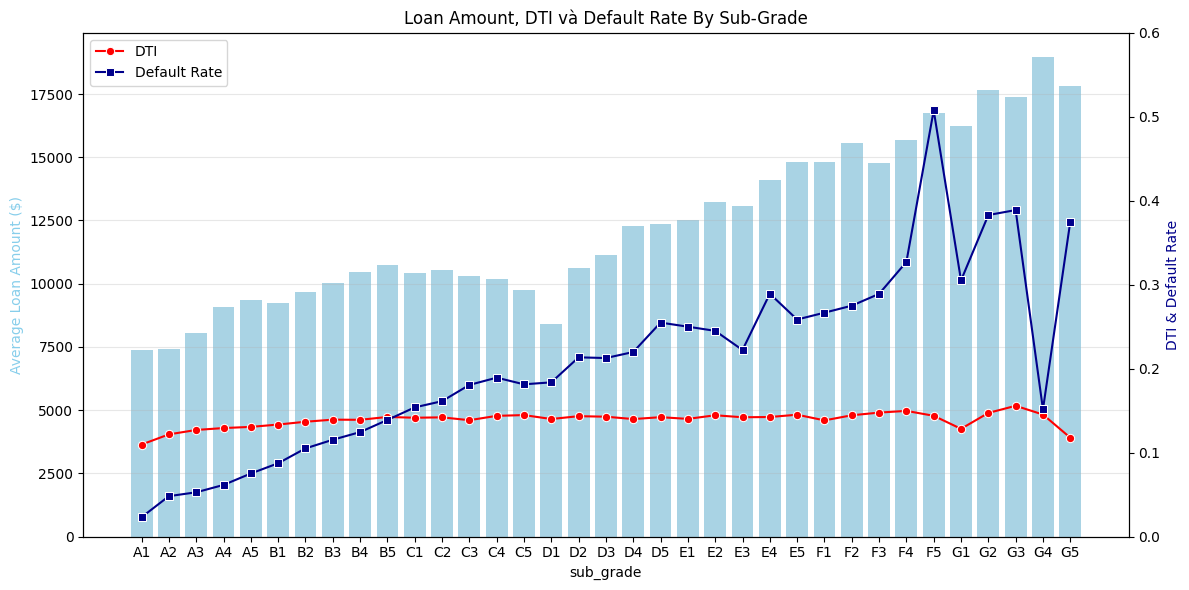

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

summary = df.groupby('sub_grade').agg({
    'loan_amount': 'mean',
    'dti': 'mean',
    'is_default': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=summary, x='sub_grade', y='loan_amount',
            color='skyblue', alpha=0.8, ax=ax1)
ax1.set_ylabel('Average Loan Amount ($)', color='skyblue')

ax2 = ax1.twinx()
sns.lineplot(data=summary, x='sub_grade', y='dti',
             color='red', marker='o', label='DTI', ax=ax2)
sns.lineplot(data=summary, x='sub_grade', y='is_default',
             color='darkblue', marker='s', label='Default Rate', ax=ax2)
ax2.set_ylabel('DTI & Default Rate', color='darkblue')
ax2.set_ylim(0, 0.6)

# Legend gộp + title
ax1.set_title('Loan Amount, DTI và Default Rate By Sub-Grade')
ax1.grid(axis='y', alpha=0.3)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [90]:
# @title Văn bản tiêu đề mặc định

import pandas as pd
import numpy as np

def calculate_rate(loan_term, installment, total_payment, tol=1e-10, max_iter=1000):
    if installment <= total_payment / loan_term:  # Lãi suất <= 0%
        return 0.0

    low = 0.0
    high = 1.0  # Giới hạn rộng (0% đến 1200%/năm mỗi kỳ)

    for _ in range(max_iter):
        mid = (low + high) / 2
        power = (1 + mid) ** loan_term

        if power <= 1:
            installment_calc = total_payment / loan_term
        else:
            installment_calc = total_payment * mid * power / (power - 1)

        if abs(installment_calc - installment) < tol * installment:
            return mid

        if installment_calc < installment:
            low = mid
        else:
            high = mid

    return mid


df['r'] = df.apply(
    lambda row: calculate_rate(row['loan_term'], row['installment'], row['total_payment']),
    axis=1
)

df['r_year_percent'] = round(df['r'] * 12 * 100,2)
print(df[['total_payment', 'installment', 'loan_term', 'r', 'r_year_percent']].head())

   total_payment  installment  loan_term             r  r_year_percent
0           3835       106.53         36  1.127584e-06            0.00
1           3210       148.32         36  3.058663e-02           36.70
2           8686       241.28         36  4.978501e-07            0.00
3           3014        90.48         36  4.257587e-03            5.11
4           8765       243.49         36  3.946814e-06            0.00
